# Airline Business Intelligence – Phase 2 Data Quality Snapshot

This notebook is a quick **smoke test** for Phase 2 of the pipeline:

- OpenFlights reference data (`airports`, `airlines`)
- Synthetic flight schedule (`flights`)
- BTS on-time performance (`flight_performance`)
- Synthetic customers & loyalty (`passengers`, `loyalty_accounts`, `miles_transactions`)
- Synthetic revenue (`bookings`, `payments`)

Assumptions:

- PostgreSQL is running
- The `airline` schema has been migrated
- The environment variable `DATABASE_URL` points at the `airline_bi` database


In [1]:
import os
from textwrap import dedent

import pandas as pd
from sqlalchemy import create_engine

db_url = os.getenv("DATABASE_URL")
if not db_url:
    raise RuntimeError("DATABASE_URL is not set – export it before running this notebook.")

engine = create_engine(db_url, future=True)


In [2]:
import os
from textwrap import dedent

import pandas as pd
from sqlalchemy import create_engine

db_url = os.getenv("DATABASE_URL")
if not db_url:
    raise RuntimeError("DATABASE_URL is not set – export it before running this notebook.")

engine = create_engine(db_url, future=True)


## 1. Row counts by table


In [4]:

def run_sql(query: str) -> pd.DataFrame:
    """Run a SQL query and return a pandas DataFrame."""
    with engine.begin() as con:
        return pd.read_sql_query(dedent(query), con)

row_counts_sql = """
    SELECT 'airports'            AS table_name, COUNT(*) AS row_count FROM airline.airports
    UNION ALL
    SELECT 'airlines',           COUNT(*) FROM airline.airlines
    UNION ALL
    SELECT 'flights',            COUNT(*) FROM airline.flights
    UNION ALL
    SELECT 'flight_performance', COUNT(*) FROM airline.flight_performance
    UNION ALL
    SELECT 'passengers',         COUNT(*) FROM airline.passengers
    UNION ALL
    SELECT 'loyalty_accounts',   COUNT(*) FROM airline.loyalty_accounts
    UNION ALL
    SELECT 'miles_transactions', COUNT(*) FROM airline.miles_transactions
    UNION ALL
    SELECT 'bookings',           COUNT(*) FROM airline.bookings
    UNION ALL
    SELECT 'payments',           COUNT(*) FROM airline.payments
    ORDER BY table_name;
"""

row_counts = run_sql(row_counts_sql)
row_counts


,table_name,row_count
0,airlines,5733
1,airports,7697
2,bookings,40000
3,flight_performance,22595
4,flights,5000
5,loyalty_accounts,3000
6,miles_transactions,10576
7,passengers,5000
8,payments,40000


## 2. Basic null checks on key columns

In [6]:
null_checks_sql = """
SELECT 'airports' AS table_name,
       COUNT(*)   AS total_rows,
       SUM(CASE WHEN iata_code IS NULL THEN 1 ELSE 0 END) AS metric_1_nulls,
       SUM(CASE WHEN icao_code IS NULL THEN 1 ELSE 0 END) AS metric_2_nulls
FROM airline.airports
UNION ALL
SELECT 'airlines' AS table_name,
       COUNT(*)   AS total_rows,
       SUM(CASE WHEN iata_code IS NULL THEN 1 ELSE 0 END) AS metric_1_nulls,
       SUM(CASE WHEN icao_code IS NULL THEN 1 ELSE 0 END) AS metric_2_nulls
FROM airline.airlines
UNION ALL
SELECT 'passengers' AS table_name,
       COUNT(*)   AS total_rows,
       SUM(CASE WHEN email IS NULL THEN 1 ELSE 0 END)          AS metric_1_nulls,
       SUM(CASE WHEN state_or_country IS NULL THEN 1 ELSE 0 END) AS metric_2_nulls
FROM airline.passengers
UNION ALL
SELECT 'bookings' AS table_name,
       COUNT(*)   AS total_rows,
       SUM(CASE WHEN passenger_id IS NULL THEN 1 ELSE 0 END) AS metric_1_nulls,
       SUM(CASE WHEN flight_id    IS NULL THEN 1 ELSE 0 END) AS metric_2_nulls
FROM airline.bookings
UNION ALL
SELECT 'payments' AS table_name,
       COUNT(*)   AS total_rows,
       SUM(CASE WHEN booking_id IS NULL THEN 1 ELSE 0 END) AS metric_1_nulls,
       SUM(CASE WHEN amount_usd IS NULL THEN 1 ELSE 0 END) AS metric_2_nulls
FROM airline.payments
ORDER BY table_name;
"""
null_checks = run_sql(null_checks_sql)
null_checks



,table_name,total_rows,metric_1_nulls,metric_2_nulls
0,airlines,5733,4619,172
1,airports,7697,1625,0
2,bookings,40000,0,0
3,passengers,5000,0,0
4,payments,40000,0,0


In [7]:
flights_nulls_sql = """
SELECT
    COUNT(*) AS total_rows,
    SUM(CASE WHEN airline_id          IS NULL THEN 1 ELSE 0 END) AS airline_id_nulls,
    SUM(CASE WHEN aircraft_id         IS NULL THEN 1 ELSE 0 END) AS aircraft_id_nulls,
    SUM(CASE WHEN route_id            IS NULL THEN 1 ELSE 0 END) AS route_id_nulls,
    SUM(CASE WHEN origin_airport_id   IS NULL THEN 1 ELSE 0 END) AS origin_id_nulls,
    SUM(CASE WHEN destination_airport_id IS NULL THEN 1 ELSE 0 END) AS dest_id_nulls
FROM airline.flights;
"""
flights_nulls = run_sql(flights_nulls_sql)
flights_nulls


,total_rows,airline_id_nulls,aircraft_id_nulls,route_id_nulls,origin_id_nulls,dest_id_nulls
0,5000,0,5000,5000,0,0


## 3. Primary-key and foriegn-key sanity checks 

In [8]:
pk_fk_sql = """
    -- PK uniqueness checks
    SELECT 'airports_pk' AS check_name,
           COUNT(*) - COUNT(DISTINCT airport_id) AS issue_count
    FROM airline.airports
    UNION ALL
    SELECT 'airlines_pk',
           COUNT(*) - COUNT(DISTINCT airline_id)
    FROM airline.airlines
    UNION ALL
    SELECT 'flights_pk',
           COUNT(*) - COUNT(DISTINCT flight_id)
    FROM airline.flights
    UNION ALL
    SELECT 'passengers_pk',
           COUNT(*) - COUNT(DISTINCT passenger_id)
    FROM airline.passengers
    UNION ALL
    SELECT 'bookings_pk',
           COUNT(*) - COUNT(DISTINCT booking_id)
    FROM airline.bookings
    UNION ALL
    SELECT 'payments_pk',
           COUNT(*) - COUNT(DISTINCT payment_id)
    FROM airline.payments

    UNION ALL

    -- FK checks: flights -> airlines / airports
    SELECT 'flight_airline_fk',
           COUNT(*)
    FROM airline.flights f
    LEFT JOIN airline.airlines al ON f.airline_id = al.airline_id
    WHERE al.airline_id IS NULL

    UNION ALL

    SELECT 'flight_origin_airport_fk',
           COUNT(*)
    FROM airline.flights f
    LEFT JOIN airline.airports a ON f.origin_airport_id = a.airport_id
    WHERE a.airport_id IS NULL

    UNION ALL

    SELECT 'flight_destination_airport_fk',
           COUNT(*)
    FROM airline.flights f
    LEFT JOIN airline.airports a ON f.destination_airport_id = a.airport_id
    WHERE a.airport_id IS NULL

    UNION ALL

    -- bookings / payments FKs
    SELECT 'booking_flight_fk',
           COUNT(*)
    FROM airline.bookings b
    LEFT JOIN airline.flights f ON b.flight_id = f.flight_id
    WHERE f.flight_id IS NULL

    UNION ALL

    SELECT 'booking_passenger_fk',
           COUNT(*)
    FROM airline.bookings b
    LEFT JOIN airline.passengers p ON b.passenger_id = p.passenger_id
    WHERE p.passenger_id IS NULL

    UNION ALL

    SELECT 'payment_booking_fk',
           COUNT(*)
    FROM airline.payments p
    LEFT JOIN airline.bookings b ON p.booking_id = b.booking_id
    WHERE b.booking_id IS NULL;
"""

pk_fk_issues = run_sql(pk_fk_sql)
pk_fk_issues


,check_name,issue_count
0,passengers_pk,0
1,flights_pk,0
2,airlines_pk,0
3,airports_pk,0
4,flight_airline_fk,0
5,flight_destination_airport_fk,0
6,flight_origin_airport_fk,0
7,booking_passenger_fk,0
8,booking_flight_fk,0
9,payment_booking_fk,0


## 4. Business sanity checks 

In [9]:
bookings_per_passenger_sql = """
    SELECT
        COUNT(*) AS total_bookings,
        COUNT(DISTINCT passenger_id) AS distinct_passengers,
        MIN(bookings_per_pax) AS min_bookings_per_passenger,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY bookings_per_pax)
            AS median_bookings_per_passenger,
        MAX(bookings_per_pax) AS max_bookings_per_passenger
    FROM (
        SELECT passenger_id, COUNT(*) AS bookings_per_pax
        FROM airline.bookings
        GROUP BY passenger_id
    ) sub;
"""

bookings_per_passenger = run_sql(bookings_per_passenger_sql)
bookings_per_passenger


,total_bookings,distinct_passengers,min_bookings_per_passenger,median_bookings_per_passenger,max_bookings_per_passenger
0,4995,4995,1,8.0,23


In [10]:
payments_summary_sql = """
    SELECT
        COUNT(*)       AS num_payments,
        SUM(amount_usd) AS total_revenue_usd,
        AVG(amount_usd) AS avg_ticket_price_usd,
        MIN(amount_usd) AS min_ticket_price_usd,
        MAX(amount_usd) AS max_ticket_price_usd
    FROM airline.payments;
"""

payments_summary = run_sql(payments_summary_sql)
payments_summary


,num_payments,total_revenue_usd,avg_ticket_price_usd,min_ticket_price_usd,max_ticket_price_usd
0,40000,4539794.86,113.494872,72.0,697.8


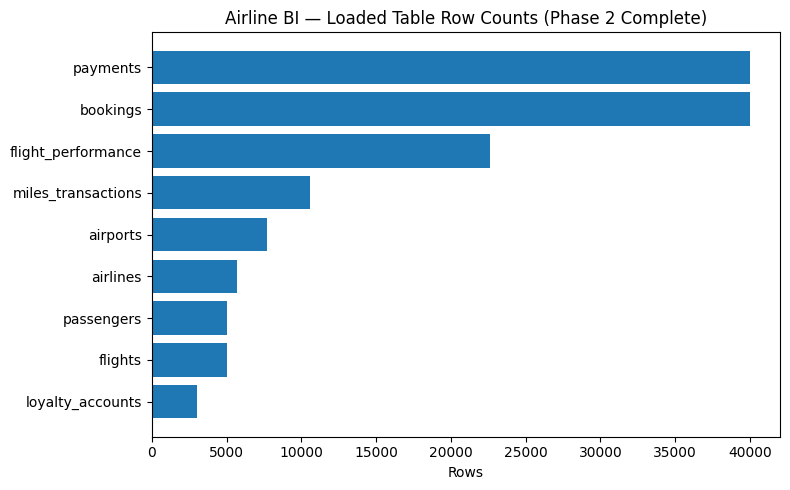

In [15]:
import matplotlib.pyplot as plt

# Simple proof-of-pipeline chart: row counts per table
df = row_counts.sort_values("row_count")

plt.figure(figsize=(8,5))
plt.barh(df["table_name"], df["row_count"])
plt.title("Airline BI — Loaded Table Row Counts (Phase 2 Complete)")
plt.xlabel("Rows")
plt.tight_layout()

plt.savefig("/Users/gracepolito/Public/Airline Business Intelligence Database/docs/pipeline_row_counts.png", dpi=200)
plt.show()